## ID calculation
Select backbone based on ID sum:

In [3]:
id1 = '308564293'
id2 = '040830861'

id_sum = sum(int(digit) for digit in (id1 + id2))
id_sum = sum(int(digit) for digit in str(id_sum))
print(f'ID digits sum is: {id_sum}, selecting MobilNet V3.')

ID digits sum is: 7, selecting MobilNet V3.


## Part 1: backbone results

In [4]:
import sys, os
# Append the datasets folder to the Python path (adjust relative path as needed)
datasets_path = os.path.join(os.getcwd(), "..", "datasets")
if datasets_path not in sys.path:
    sys.path.append(datasets_path)
from config import config

# Now use the config; note the use of bracket notation since config is a dict
path_to_voc = config["dataset_path"]
print("Dataset path:", path_to_voc)

Dataset path: /Users/fouadaz/LearningFromUniversity/Learning/IntroImageProcessing/Work_final_Project_nn/Project_DL_CV/datasets


100%|██████████| 1999639040/1999639040 [02:20<00:00, 14255063.53it/s]


Extracting /Users/fouadaz/LearningFromUniversity/Learning/IntroImageProcessing/Work_final_Project_nn/Project_DL_CV/datasets/VOCtrainval_11-May-2012.tar to /Users/fouadaz/LearningFromUniversity/Learning/IntroImageProcessing/Work_final_Project_nn/Project_DL_CV/datasets
Saved 1297 indices of images containing class 'dog'

--- Inference for VOC Image #4408 ---
1) Italian greyhound (0.4036)
2) American Staffordshire terrier (0.2396)
3) Staffordshire bullterrier (0.1018)
4) whippet (0.0608)
5) Great Dane (0.0326)

--- Inference for VOC Image #10600 ---
1) silky terrier (0.6888)
2) Yorkshire terrier (0.1185)
3) Australian terrier (0.0189)
4) Norfolk terrier (0.0044)
5) Norwich terrier (0.0030)

--- Inference for VOC Image #3663 ---
1) shovel (0.1302)
2) bannister (0.0871)
3) turnstile (0.0861)
4) coil (0.0236)
5) birdhouse (0.0202)

--- Inference for VOC Image #817 ---
1) studio couch (0.1737)
2) remote control (0.0364)
3) lipstick (0.0237)
4) nipple (0.0209)
5) candle (0.0207)

--- Inference

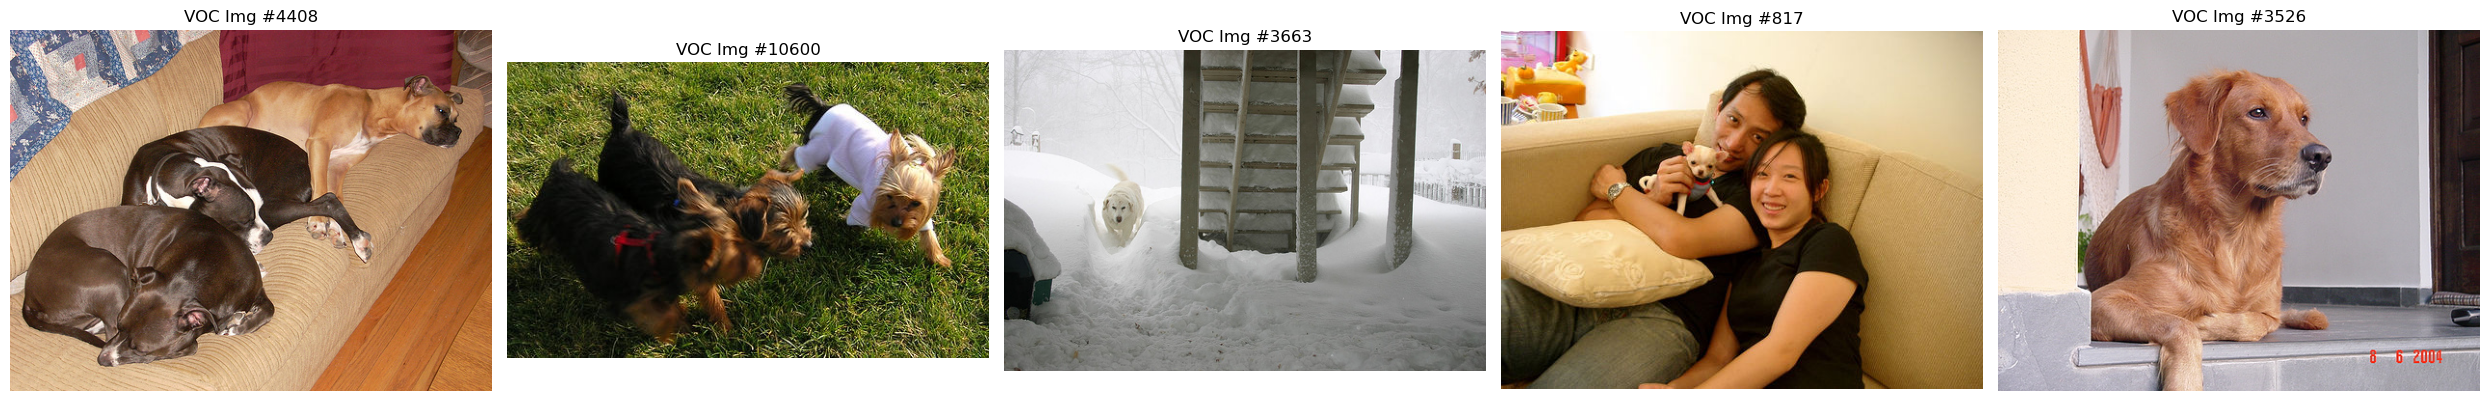

In [5]:


import os
import random
import math
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.datasets import VOCDetection

# 1) Choose your target class name
selected_class_name = "dog"

# 2) Paths and parameters
# Now indices_file is stored within your actual dataset folder defined in config
indices_file = os.path.join(config["dataset_path"], f"voc_{selected_class_name}_selected_indices.pth")
n_images = 5  # Number of images to display

# 3) Load VOC dataset
dataset = VOCDetection(
    root=path_to_voc,
    year='2012',
    image_set='trainval',
    download=True
)

# 4) Load or build indices of images containing the desired class
if os.path.exists(indices_file):
    selected_indices = torch.load(indices_file)
    print(f"Loaded {len(selected_indices)} indices from file for class '{selected_class_name}'")
else:
    # If the file does not exist, create it by scanning the dataset
    selected_indices = []
    for idx, (_, target) in enumerate(dataset):
        annotations = target['annotation']['object']
        object_names = [obj['name'] for obj in annotations]
        if selected_class_name in object_names:
            selected_indices.append(idx)
    torch.save(selected_indices, indices_file)
    print(f"Saved {len(selected_indices)} indices of images containing class '{selected_class_name}'")

# 5) Randomly sample images from the pre-filtered indices
random_indices = random.sample(selected_indices, n_images)

# 6) Load pretrained MobileNet V3 and its transforms
weights = models.MobileNet_V3_Large_Weights.IMAGENET1K_V2
model = models.mobilenet_v3_large(weights=weights)
model.eval()
preprocess = weights.transforms()          # Proper image transforms
imagenet_labels = weights.meta["categories"]

# 7) Prepare a figure for displaying images and predictions
n_cols = 5
n_rows = math.ceil(n_images / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    # Get the VOC image & target
    image, target = dataset[idx]

    # Show the original image
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f"VOC Img #{idx}")

    # Preprocess for MobileNet V3
    input_tensor = preprocess(image).unsqueeze(0)  # [1, 3, 224, 224]

    # Infer with MobileNet V3
    with torch.no_grad():
        output = model(input_tensor)
    probs = torch.softmax(output, dim=1)
    top5_prob, top5_catid = torch.topk(probs, 5)

    # Print predictions for demonstration
    print(f"\n--- Inference for VOC Image #{idx} ---")
    for rank in range(5):
        class_name = imagenet_labels[top5_catid[0, rank]]
        confidence = top5_prob[0, rank].item()
        print(f"{rank + 1}) {class_name} ({confidence:.4f})")

# Clean up extra empty axes if fewer than the total grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()